[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/fig_1.ipynb)

Asian-option pricing using 2D advection-diffusion solver   
MSc project by Paweł Magnuszewski (pmagnus@student.agh.edu.pl)

In [12]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [13]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"

In [92]:
from functools import lru_cache
from types import SimpleNamespace

import numba
import numpy as np
from matplotlib import pyplot, colors
from pystrict import strict
from ipywidgets import IntProgress

from open_atmos_jupyter_utils import show_plot, show_anim

from PyMPDATA import Options, ScalarField, Solver, Stepper, VectorField
from PyMPDATA.boundary_conditions import Extrapolated, Constant
from PyMPDATA.impl.traversals_common import make_fill_halos_loop
from PyMPDATA.impl.enumerations import SIGN_LEFT, ARG_FOCUS, META_AND_DATA_META, META_AND_DATA_DATA, OUTER, INNER
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973, Bjerksund_and_Stensland_1993

In [93]:
OPTIONS = {
    "n_iters": 3,
    "infinite_gauge": False,
    "nonoscillatory": True,
    "divergent_flow": False,
    "third_order_terms": False,
    "non_zero_mu_coeff": True,
}

In [118]:
@strict
class Settings:
    params = SimpleNamespace(
        T=0.25,
        sgma=0.2,
        r=0.1,
        K=100,
    )

    # <note: INTERPRETTED AS CELL CENTERS!>
    S_min = 80
    S_max = 120
    S_match = params.K + 1e-1
    # </note>

    l2_opt = 2
    C_opt = 0.05
    
    def terminal_value(self, A: np.ndarray):
        """ A is a 1d array, the payoff is the max of the average price minus the strike price
        however, we need to transform it into a 2d array, that is square """
        payoff = np.maximum(0, A - self.params.K)
        payoff = np.repeat([payoff], payoff.shape[0], axis=0)
        return np.exp(-self.params.r * self.params.T) * payoff

In [119]:
class Simulation:
    def __init__(self, settings):
        sgma2 = pow(settings.params.sgma, 2)
        # TODO: take y-dimension Courant number into account here (instead of the multiplier below)
        dx_opt = abs(
            settings.C_opt / max(0.5 * sgma2 - settings.params.r, settings.S_max/settings.S_min/settings.params.T) * settings.l2_opt * sgma2
        )
        dt_opt = pow(dx_opt, 2) / sgma2 / settings.l2_opt

        # adjusting dt so that nt is integer
        self.dt = settings.params.T
        self.nt = 0
        while self.dt > dt_opt:
            self.nt += 1
            self.dt = settings.params.T / self.nt

        # adjusting dx to match requested l^2
        dx = np.sqrt(settings.l2_opt * self.dt) * settings.params.sgma

        # arbitrary grid refinement for the second dimension advector
        multiplier = 1
        self.dt /= multiplier
        self.nt *= multiplier

        # calculating actual Courant number and lambda^2
        courant_number_x = -(0.5 * sgma2 - settings.params.r) * (-self.dt) / dx
        self.l2 = dx * dx / sgma2 / self.dt

        # adjusting nx and setting S_beg, S_end
        S_beg = settings.S_match
        nx = 1
        while S_beg > settings.S_min:
            nx += 1
            S_beg = np.exp(np.log(settings.S_match) - nx * dx)

        self.ix_match = nx

        S_end = settings.S_match
        while S_end < settings.S_max:
            nx += 1
            S_end = np.exp(np.log(S_beg) + (nx - 1) * dx)

        # asset price
        self.S = np.exp(np.log(S_beg) + np.arange(nx) * dx)

        dy = dx
        ny = nx

        self.mu_coeff = (0.5 / self.l2, 0)

        advectee = settings.terminal_value(A=self.S)
        
        options = Options(**OPTIONS)
        stepper = Stepper(options=options, n_dims=len(advectee.shape))

        x_dim_advector = np.full(
            (advectee.shape[0] + 1, advectee.shape[1]),
            courant_number_x,
            dtype=options.dtype,
        )
        a_dim_advector = np.zeros((nx, ny + 1))
        x = np.log(self.S)
        y_edg = np.log(S_beg) + np.arange(ny + 1) * dx
        A_edg = np.exp(y_edg - dy / 2)
        for i in range(ny + 1):
            a_dim_advector[:, i] = -self.dt / dy * (
                self.S / A_edg[i]
            ) / settings.params.T

        boundary_conditions = (Extrapolated(dim=OUTER), Extrapolated(dim=INNER))
        self.solver = Solver(
            stepper=stepper,
            advectee=ScalarField(
                advectee.astype(dtype=options.dtype),
                halo=options.n_halo,
                boundary_conditions=boundary_conditions,
            ),
            advector=VectorField(
                (x_dim_advector, a_dim_advector),
                halo=options.n_halo,
                boundary_conditions=boundary_conditions,
            ),
        )
        self.rhs = np.zeros_like(advectee)

    def add_half_rhs(self):
        psi = self.solver.advectee.get()
        # for i in range(self.solver.advectee.grid[0]):
        #     for j in range(self.solver.advectee.grid[1]):
                # self.rhs[i,j] = -psi[i, j] / settings.params.T * self.S[i] / self.S[j] 
        self.rhs[:] = -psi / settings.params.T * self.S[:, np.newaxis] / self.S[np.newaxis, :]
        psi[:] = np.maximum(0, psi + self.dt * self.rhs/2)  # TODO: the maximum should best not be needed # TODO 2: should it be -dt!?

    def step(self):
        self.add_half_rhs()
        self.solver.advance(1, self.mu_coeff)
        self.add_half_rhs()

In [120]:
settings = Settings()
simulation = Simulation(settings)

In [121]:
def annotate_axes(ax):
    ax.set_xlabel("average asset price")
    ax.set_ylabel("underlying asset price")

In [122]:
def plot_advectee(advectee_array, ax, t=settings.params.T):
    ax.imshow(advectee_array, extent=(settings.S_min, settings.S_max, settings.S_min, settings.S_max), origin="lower")
    ax.set_title(f"terminal condition (advectee at t={t} years)")

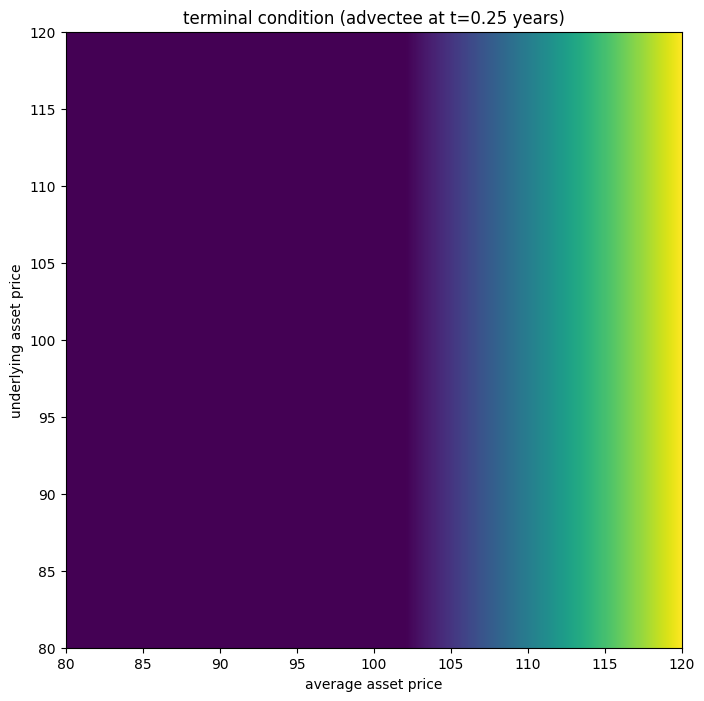

In [123]:
fig, ax = pyplot.subplots(figsize=(8, 8))
plot_advectee(simulation.solver.advectee.get(), ax)
annotate_axes(ax)
show_plot('terminal_condition.pdf', inline_format='png')

In [124]:
print(f"{simulation.solver.advectee.get().shape} is the shape of the advectee array")
print(f"{simulation.nt} is the number of time steps")

(610, 610) is the shape of the advectee array
45000 is the number of time steps


KeyboardInterrupt: 

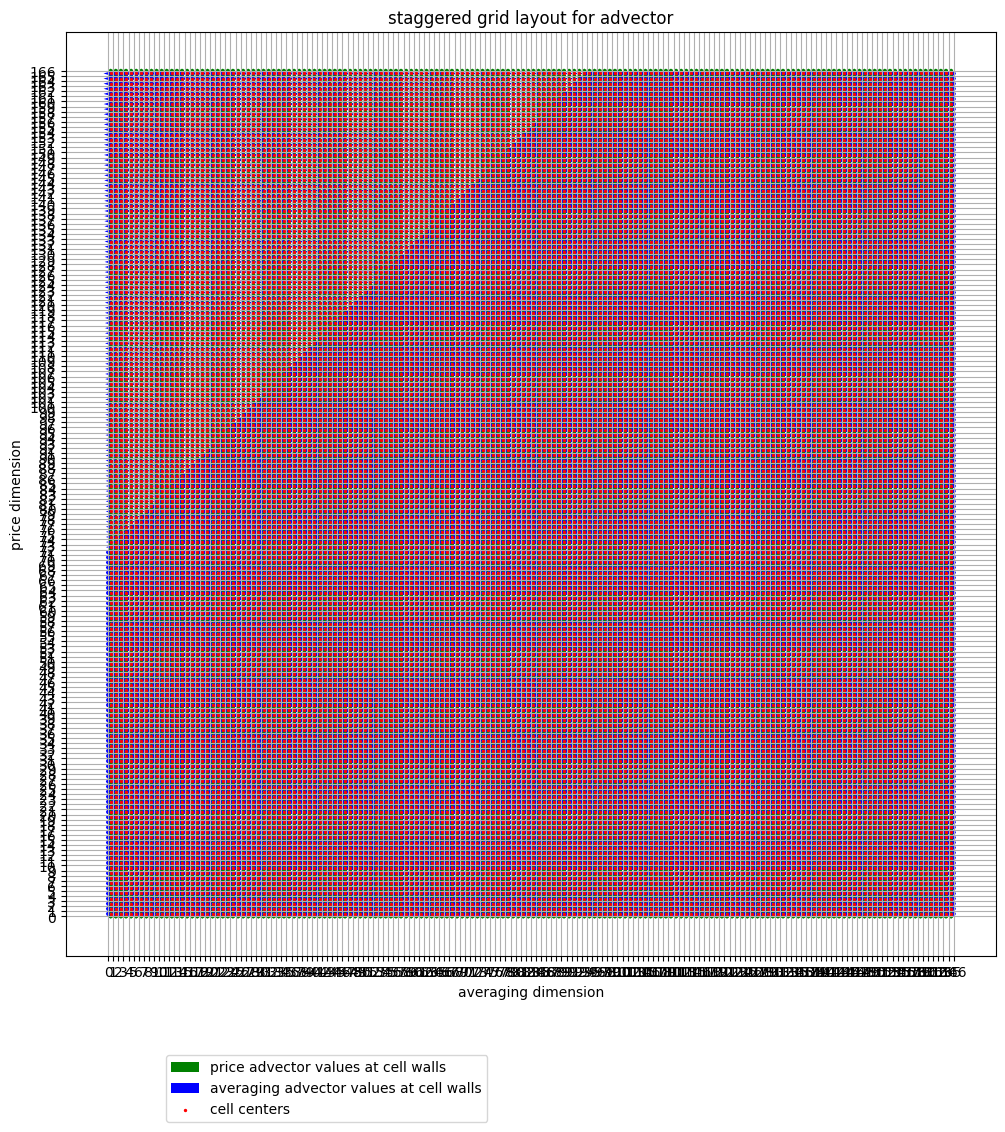

In [89]:
X = simulation.solver.advector.get_component(0)
Y = simulation.solver.advector.get_component(1)
grid = (Y.shape[0], X.shape[1])

fig, ax = pyplot.subplots(figsize=(12, 12))
ax.quiver(*np.mgrid[
        1 / 2 : grid[1] : 1,
        0: grid[0]+1 : 1,
    ], 0, X.T.flatten(), pivot='mid', color='green', width=.005,
    label='price advector values at cell walls'
)
ax.quiver(*np.mgrid[
        0: grid[1]+1 : 1,
        1 / 2 : grid[0] : 1,
    ], Y.T.flatten(), 0, pivot='mid', color='blue', width=.005,
    label='averaging advector values at cell walls'
)
ax.scatter(*np.mgrid[
        1/2: grid[1] : 1,
        1/2: grid[0] : 1
    ], color='red', label='cell centers', s=2
)

ax.axis('equal')
pyplot.title(f'staggered grid layout for advector')
pyplot.xlabel('averaging dimension')
pyplot.ylabel('price dimension')
pyplot.legend(bbox_to_anchor=(.1, -.1), loc='upper left', ncol=1)
for i, xy in enumerate(('x', 'y')):
    getattr(pyplot, f"{xy}ticks")(np.arange(0, grid[i] + 1))
pyplot.grid()
show_plot('advector.pdf')

In [ ]:
print(f"{simulation.nt} time steps will be taken")
progbar = IntProgress(max = simulation.nt)
display(progbar)


history = []
history_rhs = []
for progbar.value in range(simulation.nt + 1):
    if progbar.value != 0:
        res = simulation.step()
    history.append(simulation.solver.advectee.get().copy())
    history_rhs.append(simulation.rhs.copy())

45000 time steps will be taken


IntProgress(value=0, max=45000)

In [59]:
def plot_solution(frame_index, ax):    
    ax.plot(
        simulation.S,
        Black_Scholes_1973.c_euro(S=simulation.S, **settings.params.__dict__, b=0),
        label="European analytic solution (Black-Scholes '73)", linestyle=':'
    )
    ax.plot(
        simulation.S,
        Bjerksund_and_Stensland_1993.c_amer(S=simulation.S, **settings.params.__dict__, b=0),
        label="American analytic solution (Bjerksund & Stensland '93)", linestyle='--'
    )
    ax.plot(
        simulation.S, asian_analytic.geometric_asian_average_price_c(
            S=simulation.S,
            **settings.params.__dict__,
            dividend_yield=0
        ),
        label="Asian analytic solution (geometric, McDonald 2013)"
    )
    ax.plot(simulation.S, history[frame_index].diagonal(), label="Asian MPDATA solution (arithmetic)", marker='.')
    ax.plot(simulation.S, history[0].diagonal(), label="discretised terminal condition (discounted payoff)", marker='.', alpha=0.5)
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_title(f"option parameters: {settings.params.__dict__}")
    ax.set_xlabel("underlying S(t=0)=A(t=0) (and A(T) for terminal condition)")
    ax.set_ylabel("option price")

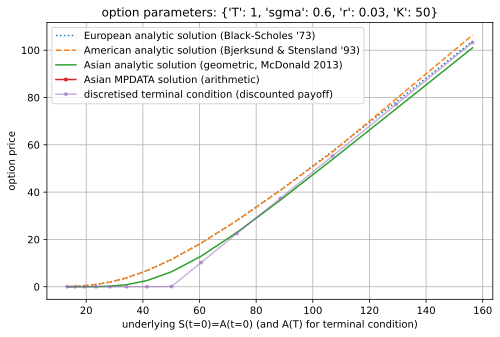

In [60]:
fig, ax = pyplot.subplots(1, 1, figsize=(8,5))
plot_solution(-1, ax)
show_plot('numeric_vs_analytic.pdf')

IntProgress(value=0, max=41)


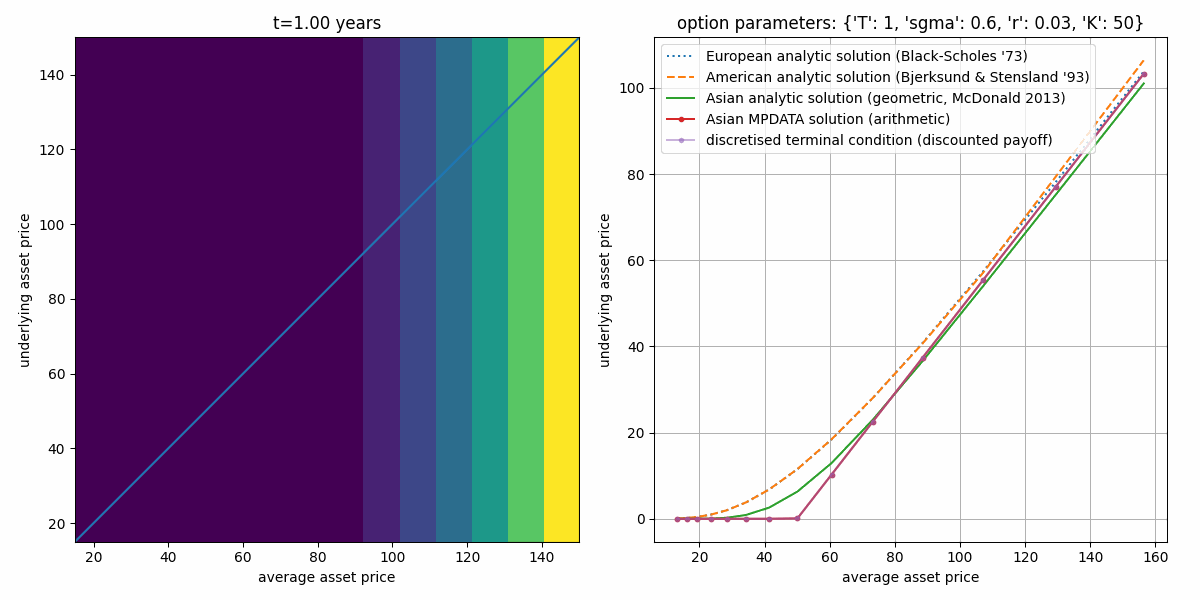

HTML(value="<a href='.\\tmp9irjaezn.gif' target='_blank'>.\\tmp9irjaezn.gif</a><br>")

In [61]:
progbar = IntProgress(max = simulation.nt+1)

def generate_anim_frame(frame_index):
    progbar.value = frame_index
    fig, axs = pyplot.subplots(1, 2, figsize=(12, 6))
    plot_advectee(history[frame_index], axs[0], t=settings.params.T - frame_index * simulation.dt)
    axs[0].plot([settings.S_min, settings.S_max], [settings.S_min, settings.S_max])
    plot_solution(frame_index, axs[1])
    axs[0].set_title(f"t={settings.params.T - frame_index * simulation.dt:.2f} years")
    annotate_axes(axs[0])
    annotate_axes(axs[1])
    fig.tight_layout()
    return fig

display(progbar)
show_anim(generate_anim_frame, range(0, len(history)), duration=0.01, loop=0)